# Tutorial for `bajes.obs.gw` module 

This tutorial shows how to use the basic objects of `bajes.obs.gw`,
* `Series`     : store and manipulate the time/frequency series
* `Noise`      : characterize and generate noise
* `Detector`   : describe response and location of detector
* `Waveform`   : generate a waveform template 

The tutorial divided in two parts:
* Analysis of GW150914 : how to visualize the strain and compare with model
* Generate injection   : how to generate an artificial data strain

# Analysis of GW150914

In order to execute this tutorial, the user should have the data of GW150914 (from Hanford-LIGO datector) available in a txt file with two columns, `[t [s], strain]`. If this requirement is not satisfied, it is possible to download the strain from terminal using the command:

`bajes_read_gwosc.py --ifo H1 --event GW150914 --srate 4096 --seglen 8 -o ./path/to/outdir/`

Otherwise, the data can be found at this [link](https://www.gw-openscience.org/events/GW150914/).

Input seglen for time series is smaller than effective seglen. The series will be truncated to get the requested input.


Text(0.5, 0, 'GPS time [s]')

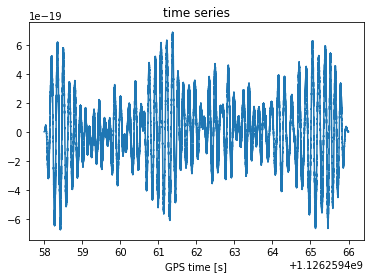

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from bajes.obs.gw import Series

# path to a strain data file, with 2 column [t [s], strain]
# this strain is the 8s segment centered around GW150914 for H1
data_path = '../test/example/data/H1_STRAIN_8_4096_1126259462.txt'
t, strain = np.genfromtxt(data_path, usecols=[0,1],unpack=True)

# set the data properties coherently
seglen = 8           # duration of the segment [s]
srate  = 4096         # sampling rate [Hz]
t_gps  = 1126259462   # central value of GPS time
f_max  = 1024
f_min  = 20 

# obs. if seglen does not match the current length of the data,
# the given strain is trncated or padded

# obs. ir the input srate does not match the sampling rate of the 
# given strain, everything will be wrong 
 
# Once the data are stored in an array (or a list), 
# it is possible to initialize a (time) series as following:

series = Series('time', strain, seglen=seglen, srate=srate, t_gps=t_gps, f_min=f_min, f_max=f_max)

fig=plt.figure()
plt.title('time series')
plt.plot(series.times, series.time_series)
plt.xlabel('GPS time [s]')

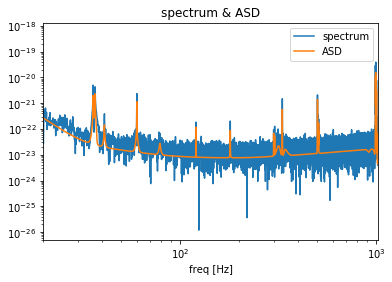

In [3]:
# once we have the data in a series, 
# we need to inilialize the noise
from bajes.obs.gw import Noise
from bajes.obs.gw.utils import read_asd

fr_asd, asd = read_asd('GW150914', 'H1')
noise       = Noise(fr_asd, asd, f_min=0, f_max=f_max)

# obs. here we are plotting together ASD and strain spectrum,
# but keep in mind that these quntities have different dimensions
# [spectrum]=Hz^-1, [ASD] = Hz^-1/2
fig=plt.figure()
plt.title('spectrum & ASD')
plt.loglog(series.freqs, np.abs(series.freq_series), label ='spectrum')
plt.loglog(noise.freqs, noise.amp_spectrum, label ='ASD')
plt.xlabel('freq [Hz]')
plt.xlim((20,1024))
plt.legend()

(1126259462.25, 1126259463.0)

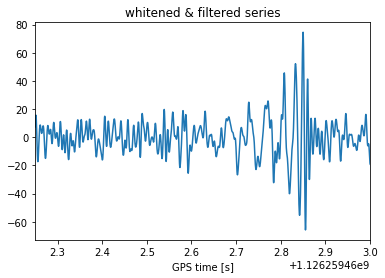

In [4]:
# in order to visualize the signal of GW150914, we need a further step
# we filter out the extra noise using a band-pass filter in the range [20,300]
series.bandpassing(flow=20, fhigh=300)

# now it is possible to compute the whitened strain 
series.whitening(noise)

fig=plt.figure()
plt.title('whitened & filtered series')
plt.plot(series.times, series.time_series )
plt.xlabel('GPS time [s]')
plt.xlim((t_gps+0.25,t_gps+1.))


Loading model from:  /miniconda3/lib/python3.7/site-packages/mlgw/TD_models/model_0/
  Loaded PCA model for amplitude with  6  PC
  Loaded PCA model for phase with  5  PC
  Loaded features for amplitude:  ['00', '11', '22', '01', '02', '12', '000', '001', '002', '011', '012', '022', '111', '112', '122', '222', '0000', '0001', '0002', '0011', '0022', '0012', '0111', '0112', '0122', '0222', '1111', '1112', '1122', '1222', '2222']
  Loaded features for phase:  ['00', '11', '22', '01', '02', '12', '000', '001', '002', '011', '012', '022', '111', '112', '122', '222', '0000', '0001', '0002', '0011', '0022', '0012', '0111', '0112', '0122', '0222', '1111', '1112', '1122', '1222', '2222']
  Loading MoE models
    Loaded amplitude model for comp:  0
    Loaded amplitude model for comp:  1
    Loaded amplitude model for comp:  2
    Loaded amplitude model for comp:  3
    Loaded amplitude model for comp:  4
    Loaded amplitude model for comp:  5
    Loaded phase model for comp:  0
    Loaded pha

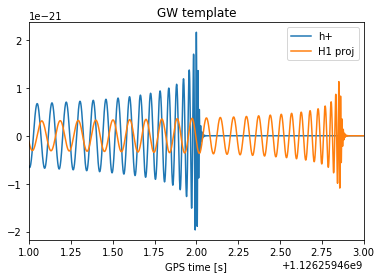

In [15]:
# now it is possible to compare a waveform model with the observed data,
# but first we need to inizialize the detector and the waveform model
from bajes.obs.gw import Detector, Waveform

# for this example we use the NRSur7dq4 aproximant
approx = 'MLGW'

det   = Detector('H1', t_gps=t_gps)
det.store_measurement(series, noise)
wave  = Waveform(series.freqs, srate, seglen, approx)

# TDWaveform (and FDWavform) is able to read a dictionary of parameters

params = {'mchirp'     : 30.,    # chirp mass [solar masses]
          'q'          : 1.2,      # mass ratio 
          's1x'        : 0.,      # primary spin parameter, x component
          's1y'        : 0.,      # primary spin parameter, y component
          's1z'        : 0.,      # primary spin parameter, z component
          's2x'        : 0.,      # secondary spin parameter, x component
          's2y'        : 0.,      # secondary spin parameter, y component
          's2z'        : 0.,      # secondary spin parameter, z component
          'lambda1'    : 0.,      # primary tidal parameter 
          'lambda2'    : 0 ,      # secondary tidal parameter
          'distance'   : 380.,    # distance [Mpc]
          'iota'       : np.pi,   # inclination [rad]
          'ra'         : 1.7,     # right ascension [rad]
          'dec'        : -0.75,   # declination [rad]
          'psi'        : 0.,      # polarization angle [rad]
          'time_shift' : 0.419,   # time shift from GPS time [s]
          'phi_ref'    : 0.,     # phase shift [rad]
          'f_min'      : 20.,     # minimum frequency [Hz]
          'srate'      : srate,   # sampling rate [Hz]
          'seglen'     : seglen,  # segment duration [s] 
          'tukey'      : 0.1,     # parameter for tukey window 
          't_gps'      : t_gps }  # GPS trigger time 

# passing the dictionary to TDWaveform.compute_hphc, 
# the object will create two array representing the strains
# of two polarizations evaluated on the given time axis
hpc = wave.compute_hphc(params)

# then it is possible to project the waveform on a given 
# detector using the method project_tdwave
proj_wave = det.project_tdwave(hpc,params,wave.domain)

# NOTE:
# The method compute_hphc returns the GW polarizations in time-domain 
# or frequency-domain, depending on the requested approximant.
# However, the method project_tdwave [or project_fdwave] will project
# the polarizations and it returns the waveform  always in time-domain 
# [or frequency-domain, for project_fdwave]

fig = plt.figure()
plt.title('GW template')
plt.plot(series.times, hpc.plus , label = 'h+')
plt.plot(series.times, proj_wave  , label = 'H1 proj')
plt.xlabel('GPS time [s]')
plt.xlim((t_gps-1,t_gps+1))
plt.legend()

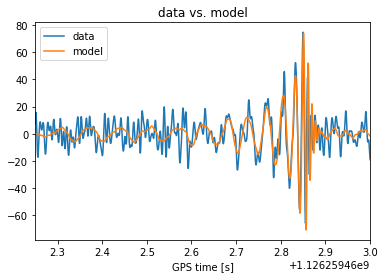

In [16]:
# now if we want to compare the whitened-filtered signal of GW150914,
# we have to whiten also the waveform. 
# So we generate a Series with the projected waveform 
proj_series = Series('time', proj_wave, seglen=seglen, srate=srate, 
                     t_gps=t_gps, f_min=f_min, f_max=f_max)
proj_series.whitening(noise)

fig=plt.figure()
plt.title('data vs. model')
plt.plot(series.times, series.time_series , label = 'data')
plt.plot(proj_series.times, proj_series.time_series , label = 'model')
plt.xlim((t_gps+0.25,t_gps+1.0))
plt.xlabel('GPS time [s]')
plt.legend()

Input seglen for time series is smaller than effective seglen. The series will be truncated to get the requested input.


Max SNR in H1 :  19.42481899612395


(-0.15, 0.15)

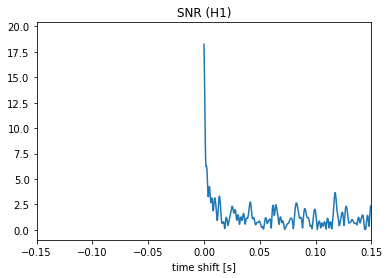

In [17]:
# then we can compute the SNR as a function of time.
# obs. note that for this computation we are going to use the pure freq. series.
# and we have to redefine f_min (and then our series, since we have to cut the freq axis)

series = Series('time', strain, seglen=seglen, srate=srate, t_gps=t_gps, f_min=f_min, f_max=f_max)
proj_series = Series('time', proj_wave, seglen=seglen, srate=srate, t_gps=t_gps, f_min=f_min, f_max=f_max)
t_snr, snr    = series.snr_phimax(proj_series, noise)

print("Max SNR in H1 : ", np.max(snr))

fig=plt.figure()
plt.title('SNR (H1)')
plt.plot(t_snr, snr)
plt.xlabel('time shift [s]')
plt.xlim((-0.15,0.15))

# Noise generation

In this example, we generate an arificial data strain, technically called `injection`. In order to  perform an injection, we have to generare an artificial noise strain (from a given PSD) and include in these data an artificial waveform template, projected on the respective detector. 

We use the LIGO design PSD.

Text(0.5, 0, 'GPS time [s]')

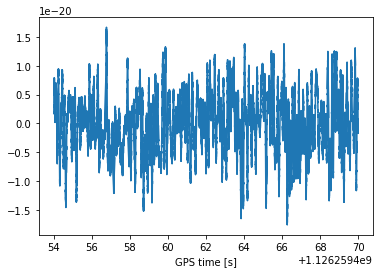

In [18]:
# let's re-inizialize the noise object
import numpy as np
import matplotlib.pyplot as plt

from bajes.obs.gw import Noise
from bajes.obs.gw.utils import read_asd

t_gps  = 1126259462
seglen = 16
srate  = 4096 

fr_asd, asd = read_asd('design', 'H1')
noise       = Noise(fr_asd, asd, f_min=0)
n_strain    = noise.generate_fake_noise(seglen, srate, t_gps)
time        = np.arange(len(n_strain))*(1./srate) + t_gps - seglen/2.

plt.plot(time,n_strain)
plt.xlabel(r'GPS time [s]')


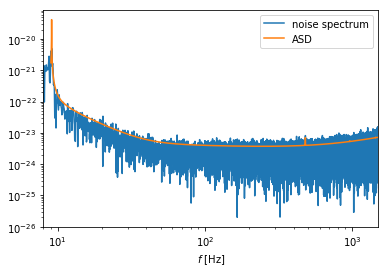

In [19]:
# comparison between the actual ASD and the noise spectrums
from bajes.obs.gw.strain import fft, windowing
n_strain_wind, window_fact = windowing(n_strain, alpha=0.1)
n_fr, n_fft = fft(n_strain_wind , 1./srate)

plt.loglog(n_fr,np.abs(n_fft)*np.sqrt(window_fact/seglen),label='noise spectrum')
plt.loglog(noise.freqs,noise.amp_spectrum,label='ASD')
plt.xlabel(r'$f$ [Hz]')
plt.xlim((8,1500))
plt.legend()

In [21]:
# Now it is possible to generate a template and project it on the selected detector
# (as it is shown above), in order to create a full injection. 
# This procedure is automatically performed be the executable bajes_inject.py